# **INFO-6147 DEEP LEARNING WITH PYTORCH**

## **NAME - DEEP NARESH PATEL**

## **STUDENT NUMBER - 1247540**

## **•	INTRODUCTION:**

This project presents methods like Image Classification to detect, quantify and predict plant diseases. Although disease symptoms can manifest in any part of the plant, only methods that explore visible symptoms in leaves will be considered. Crop diseases are a major threat to food security, but their rapid identification remains difficult in many parts of the world due to the lack of the necessary infrastructure. Sugarcane is one of the most important agricultural crops in the world. Sugarcane is a long durational crop due to this it is prone to more diseases. This venture is to observe the effectiveness of Image Classification techniques for the detection of illnesses in sugarcane plants by way of the use of Classification Models (like Convolutional Neural Networks (CNN) to distinguish unique plant diseases).


In [ ]:
# Importing the necessary libraries...

from google.colab import drive
import os
from torchvision import transforms

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import random
from PIL import Image
from collections import Counter

from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt
import torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR

In [ ]:
# Mount Google Drive...
drive.mount('/content/drive')

# Define the dataset path...
dataset_path = '/content/drive/My Drive/Colab Notebooks/PyTorch/Project/Dataset'

# Check the directory structure...
assert os.path.exists(dataset_path), "Dataset path does not exist. Please check the path."
print("Dataset structure:")
print(os.listdir(dataset_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset structure:
['Nitrogen Deficit', 'Leaf Mite', 'Leaf Scorch', 'Common Rust', 'Healthy', 'Eyespot', 'Mosaic Virus', 'Red Rot', 'Potassium Deficit']


In [ ]:
# Basic transformations for all classes...
basic_transforms = transforms.Compose([
    transforms.Resize((224, 224)),           # Standardize image dimensions...
    transforms.ToTensor(),                   # Convert to PyTorch tensor...
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize (mean and standard deviation values of RGB channels, used for datasets like ImageNet.)...
])

# Augmentations for minority classes...
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Defining a class to balance the classes in the dataset...

class BalancedImageDataset(Dataset):
    def __init__(self, root, transform, augment_transform=None):
        self.dataset = ImageFolder(root=root)
        self.transform = transform
        self.augment_transform = augment_transform

        # Class-wise data counts...
        self.class_to_indices = {cls: [] for cls in range(len(self.dataset.classes))}
        for idx, (_, label) in enumerate(self.dataset.samples):
            self.class_to_indices[label].append(idx)

        # Class counts...
        self.class_counts = {cls: len(indices) for cls, indices in self.class_to_indices.items()}
        self.max_count = max(self.class_counts.values())  # Determining the majority class size...

        # Generating balanced samples...
        self.balanced_samples = self._generate_balanced_samples()

    def _generate_balanced_samples(self):
        balanced_samples = []
        for cls, indices in self.class_to_indices.items():
            balanced_samples.extend([(idx, False) for idx in indices])  # Adding original samples...
            if len(indices) < self.max_count:  # Augmenting for minority classes...
                augment_needed = self.max_count - len(indices)
                balanced_samples.extend([(random.choice(indices), True) for _ in range(augment_needed)])
        return balanced_samples

    def __len__(self):
        return len(self.balanced_samples)

    def __getitem__(self, idx):
        sample_idx, is_augmented = self.balanced_samples[idx]
        image_path, label = self.dataset.samples[sample_idx]
        image = Image.open(image_path).convert("RGB")

        if is_augmented and self.augment_transform:
            image = self.augment_transform(image)
        else:
            image = self.transform(image)

        return image, label


In [ ]:
# Loading the full dataset...
full_dataset = BalancedImageDataset(root=dataset_path, transform=basic_transforms, augment_transform=augmentation_transforms)

# Spliting dataset into train, validation, and test sets (80%, 10%, 10%)...
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Creating DataLoaders for train, validation, and test sets...
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Checking dataset distribution...
all_labels = [label for _, label in full_dataset]
label_counts = Counter(all_labels)

print(f"Balanced class distribution:", label_counts)
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Balanced class distribution: Counter({0: 46, 1: 46, 2: 46, 3: 46, 4: 46, 5: 46, 6: 46, 7: 46, 8: 46})
Training dataset size: 331
Validation dataset size: 41
Test dataset size: 42


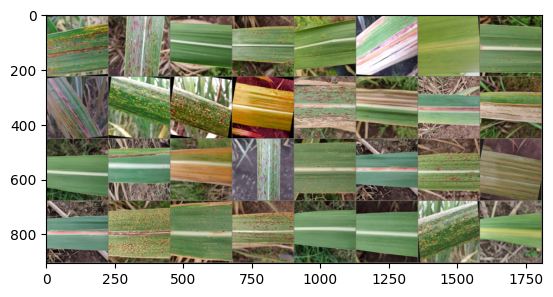

In [ ]:
# Visualizing the dataset...

# Function to unnormalize and display images...
def imshow(img, title=None):

    plt.figure(figsize=(10, 10))

    img = img.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img * std + mean  # Unnormalize...
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()

# Visualizing a batch of images...
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Creating grid of images...
out = torchvision.utils.make_grid(images)
imshow(out)


In [ ]:
# Setting device to GPU if available, otherwise fallback to CPU...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Loading the pretrained ResNet-18 model...
model = models.resnet18(pretrained=True)

# Freezing the layers (weights) of the model except the last fully connected layer...
for param in model.parameters():
    param.requires_grad = False

# Modifying the fully connected layer to match the number of classes in your dataset (9 classes)...
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9)

# Move the model to the GPU...
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Defining the loss function (CrossEntropyLoss for classification tasks)...
criterion = nn.CrossEntropyLoss()

# Defining the optimizer (only for the last fully connected layer since other layers are frozen)...
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
# Initializing lists to track training and validation metrics...
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Number of epochs...
num_epochs = 10

# Training loop...
for epoch in range(num_epochs):
    # Training phase...
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Moving inputs and labels to GPU...
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase...
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # Moving inputs and labels to GPU...
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch [1/10]
  Train Loss: 2.0768, Train Accuracy: 0.2205
  Val Loss: 1.7746, Val Accuracy: 0.4634
Epoch [2/10]
  Train Loss: 1.5846, Train Accuracy: 0.5831
  Val Loss: 1.4158, Val Accuracy: 0.6585
Epoch [3/10]
  Train Loss: 1.2417, Train Accuracy: 0.7341
  Val Loss: 1.1446, Val Accuracy: 0.8049
Epoch [4/10]
  Train Loss: 1.0023, Train Accuracy: 0.8731
  Val Loss: 0.9435, Val Accuracy: 0.8780
Epoch [5/10]
  Train Loss: 0.8630, Train Accuracy: 0.8761
  Val Loss: 0.8137, Val Accuracy: 0.9024
Epoch [6/10]
  Train Loss: 0.7111, Train Accuracy: 0.9275
  Val Loss: 0.6894, Val Accuracy: 0.9512
Epoch [7/10]
  Train Loss: 0.6022, Train Accuracy: 0.9486
  Val Loss: 0.6892, Val Accuracy: 0.9268
Epoch [8/10]
  Train Loss: 0.5262, Train Accuracy: 0.9426
  Val Loss: 0.5729, Val Accuracy: 0.9268
Epoch [9/10]
  Train Loss: 0.4733, Train Accuracy: 0.9517
  Val Loss: 0.5412, Val Accuracy: 0.9268
Epoch [10/10]
  Train Loss: 0.4471, Train Accuracy: 0.9577
  Val Loss: 0.5186, Val Accuracy: 0.9024


In [ ]:
# Evaluating on test set...

model.eval()  # Setting the model to evaluation mode...
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Moving inputs and labels to GPU...
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass...
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9286


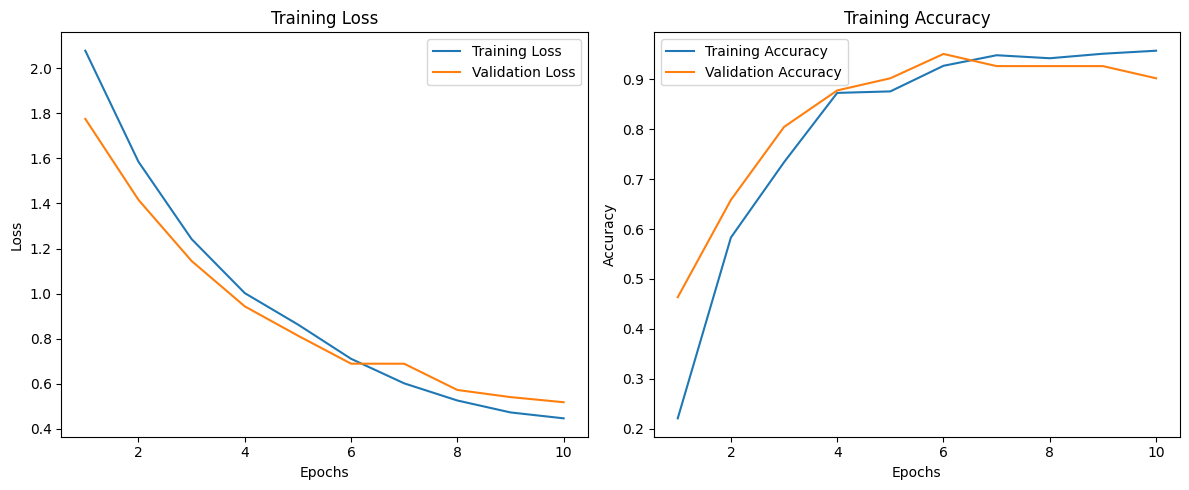

In [ ]:
# Plotting Loss...
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting Accuracy...
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# **Hyperparameter tuning with different parameters.**

In [ ]:
# Loading ResNet-18 model...
model2 = models.resnet18(pretrained=True)  # Loading pretrained weights...
num_classes = 9

# Freezing the layers (weights) of the model except the last fully connected layer...
for param in model2.parameters():
    param.requires_grad = False

# Modifying the fully connected layer to match the number of classes...
model2.fc = nn.Linear(model2.fc.in_features, num_classes)
model2 = model2.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Defining criterion...
criterion = nn.CrossEntropyLoss()

# Defining optimizer...
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

# Defining learning rate scheduler...
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)  # Reduce LR by 10x every 5 epochs...

In [ ]:
# Initializing lists to track training and validation metrics...
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Number of epochs...
num_epochs = 5

# Training loop...
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Moving inputs and labels to GPU...

        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase...
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model2(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Step the scheduler...
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

Epoch [1/5]
  Train Loss: 2.0704, Train Accuracy: 0.7157
  Val Loss: 1.1836, Val Accuracy: 0.8699
  Learning Rate: 0.010000
Epoch [2/5]
  Train Loss: 0.8387, Train Accuracy: 0.7233
  Val Loss: 0.7574, Val Accuracy: 0.8415
  Learning Rate: 0.001000
Epoch [3/5]
  Train Loss: 0.4264, Train Accuracy: 0.7479
  Val Loss: 0.5288, Val Accuracy: 0.8488
  Learning Rate: 0.001000
Epoch [4/5]
  Train Loss: 0.3211, Train Accuracy: 0.7772
  Val Loss: 0.4867, Val Accuracy: 0.8537
  Learning Rate: 0.000100
Epoch [5/5]
  Train Loss: 0.2840, Train Accuracy: 0.7986
  Val Loss: 0.4875, Val Accuracy: 0.8571
  Learning Rate: 0.000100


In [ ]:
# Evaluating on test set...

model2.eval()  # Setting the model to evaluation mode...
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Moving inputs and labels to GPU...
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass...
        outputs = model2(inputs)
        _, predicted = torch.max(outputs, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9524


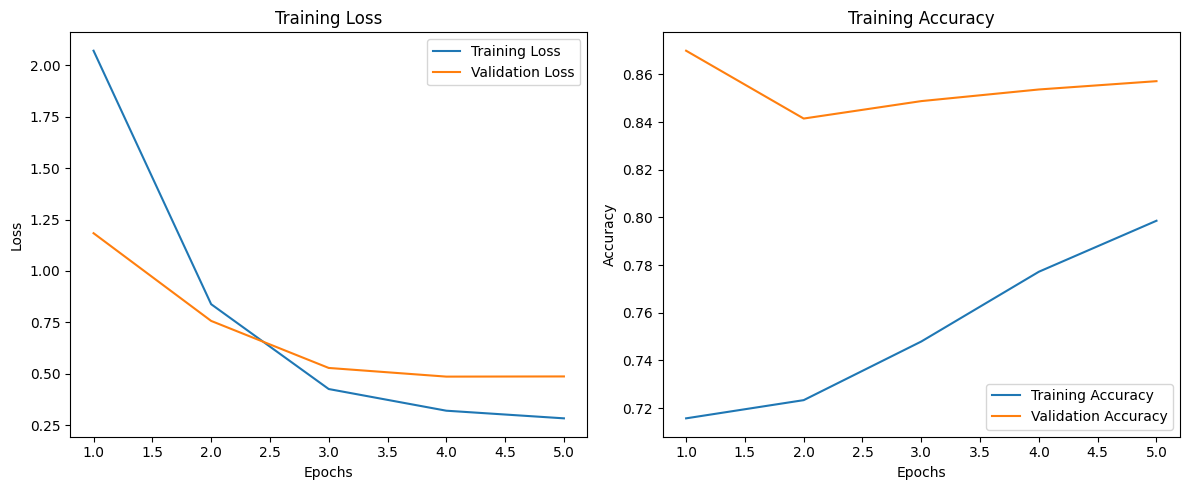

In [ ]:
# Plotting Loss...
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plotting Accuracy...
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


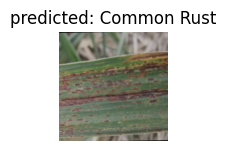

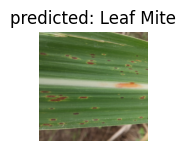

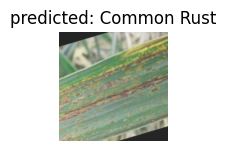

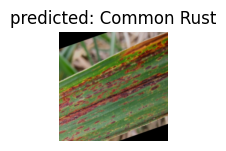

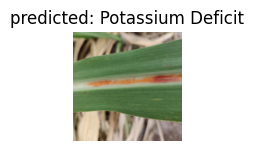

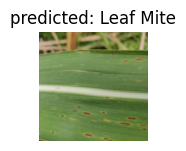

In [ ]:
# Visualizing the performance of the model...

class_names = ['Nitrogen Deficit', 'Leaf Mite', 'Leaf Scorch', 'Common Rust', 'Healthy', 'Eyespot', 'Mosaic Virus', 'Red Rot', 'Potassium Deficit']

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


visualize_model(model) # Visualizing the results of the first model (without hyperparameter tuning)...